## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = None
month = None
program = "default"
study_type = "program"
mode_of_interest = "e-bike"
include_test_users = False
is_debug_mode = False
dynamic_labels = {}

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd

from plots import *
import scaffolding

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

URL not formatted, defaulting to "Stage_database"
Connecting to database URL db


In [3]:
# Do not run this notebook at all unless it is for a program; nbclient will run up through this cell
if study_type != "program":
    ipython = get_ipython()
    ipython._showtraceback = scaffolding.no_traceback_handler
    raise Exception("The plots in this notebook are only relevant to programs")

In [4]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

## Collect Data From Database

In [5]:
expanded_ct, file_suffix, quality_text, debug_df = scaffolding.load_viz_notebook_data(year,
                                                                            month,
                                                                            program,
                                                                            study_type,
                                                                            dynamic_labels,
                                                                            dic_re,
                                                                            dic_pur=dic_pur,
                                                                            include_test_users=include_test_users)
# CASE 1 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867 
expanded_ct = scaffolding.add_energy_impact(expanded_ct, df_ei, dic_fuel, dynamic_labels) if len(expanded_ct) > 0 else expanded_ct

0          4c_AGgrHoywg5gYmyL8
1          4c_Ri332Xj3DKaCrdwl
2          4c_6gzfgbVUODrbTdc_
3          4c_eJEIg2mWQYU3ISXU
4          4c_s7jHZr7a0yQOAa1b
                ...           
239    fc_csu_TMUSjqGBWELwW5mZ
240    fc_n2n__1f8tgZOmeizn0pJ
241    fc_n2n_xV9QUA9nMEVPYq1B
242    fc_csu_OZ_EXMB-w436dbCh
243    fc_n2n_gIVaKBYQtpjA7s5-
Name: user_email, Length: 244, dtype: object

Loaded all confirmed trips of length 135471


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 134985 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,7,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,7,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,7,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,7,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,7,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09


After filtering, found 49952 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,21,10,31,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,21,20,5,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,22,10,15,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,22,15,21,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,22,15,32,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312


,mode_confirm,purpose_confirm,replaced_mode
0,drove_alone,work,NaN
1,drove_alone,home,NaN
2,drove_alone,work,NaN
3,drove_alone,meal,NaN
4,drove_alone,meal,NaN


After expanding, columns went from 39 -> 42


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,user_id_str,mode_confirm,purpose_confirm,replaced_mode
0,DwellSegmentationTimeFilter,1.626885e+09,2021-07-21T10:31:16-06:00,"{'type': 'Point', 'coordinates': [-107.8599774...",60f85d2453f7233da0b1a28c,1.626884e+09,2021-07-21T10:13:12.769000-06:00,"{'type': 'Point', 'coordinates': [-107.8579336...",1083.231000,9413.891182,...,16,2,America/Denver,612089e1cb13df1d4d22cfd9,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
1,DwellSegmentationTimeFilter,1.626920e+09,2021-07-21T20:05:41.808000-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",60f8dbb173697eb577aaff42,1.626918e+09,2021-07-21T19:38:56.389000-06:00,"{'type': 'Point', 'coordinates': [-107.7964539...",1605.419000,13124.152280,...,41,2,America/Denver,612089e1cb13df1d4d22cfda,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,home,NaN
2,DwellSegmentationTimeFilter,1.626971e+09,2021-07-22T10:15:32.259000-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",60f9aea3f399df93fdc1ab41,1.626969e+09,2021-07-22T09:51:21.159484-06:00,"{'type': 'Point', 'coordinates': [-107.8643886...",1451.099516,10587.088615,...,32,3,America/Denver,612089e1cb13df1d4d22cfdb,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,work,NaN
3,DwellSegmentationTimeFilter,1.626989e+09,2021-07-22T15:21:31-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",60f9f4f122abd49191e21f5c,1.626988e+09,2021-07-22T15:14:35.056996-06:00,"{'type': 'Point', 'coordinates': [-107.860199,...",415.943004,3362.028245,...,31,3,America/Denver,612089e1cb13df1d4d22cfdc,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN
4,DwellSegmentationTimeFilter,1.626990e+09,2021-07-22T15:32:52.960000-06:00,"{'type': 'Point', 'coordinates': [-107.8601932...",60f9f4f122abd49191e21f5e,1.626989e+09,2021-07-22T15:24:53.289799-06:00,"{'type': 'Point', 'coordinates': [-107.8743952...",479.670201,4084.311560,...,52,3,America/Denver,612089e2cb13df1d4d22cfdd,e9e479e9-5c3f-4345-a885-dadb7999b312,1.629522e+09,e9e479e9-5c3f-4345-a885-dadb7999b312,drove_alone,meal,NaN


_default
Based on 49952 confirmed trips from 145 users
of 111164 total trips from 148 users (44.94%)


In [ ]:
if 'mode_confirm' in expanded_ct.columns:
    mode_of_interest_df = expanded_ct.query(f"mode_confirm == '{mode_of_interest}'")
    debug_df.loc[f"{mode_of_interest}_trips"] = len(mode_of_interest_df)
    debug_df.loc[f"{mode_of_interest}_trips_with_replaced_mode"] = scaffolding.trip_label_count("Replaced_mode", mode_of_interest_df)

## Energy Impacts Relative to Specific Mode

In [6]:
# CASE 2 of https://github.com/e-mission/em-public-dashboard/issues/69#issuecomment-1256835867
data_eb = expanded_ct.query(f"mode_confirm == '{mode_of_interest}'") if "mode_confirm" in expanded_ct.columns else expanded_ct

In [7]:
quality_text_mode = scaffolding.get_quality_text(expanded_ct, data_eb, mode_of_interest)

Based on 14770 confirmed pilot_ebike trips from 130 users
of 49952 total trips from 145 users (29.57%)


### Sketch of energy impact by trips for specified mode

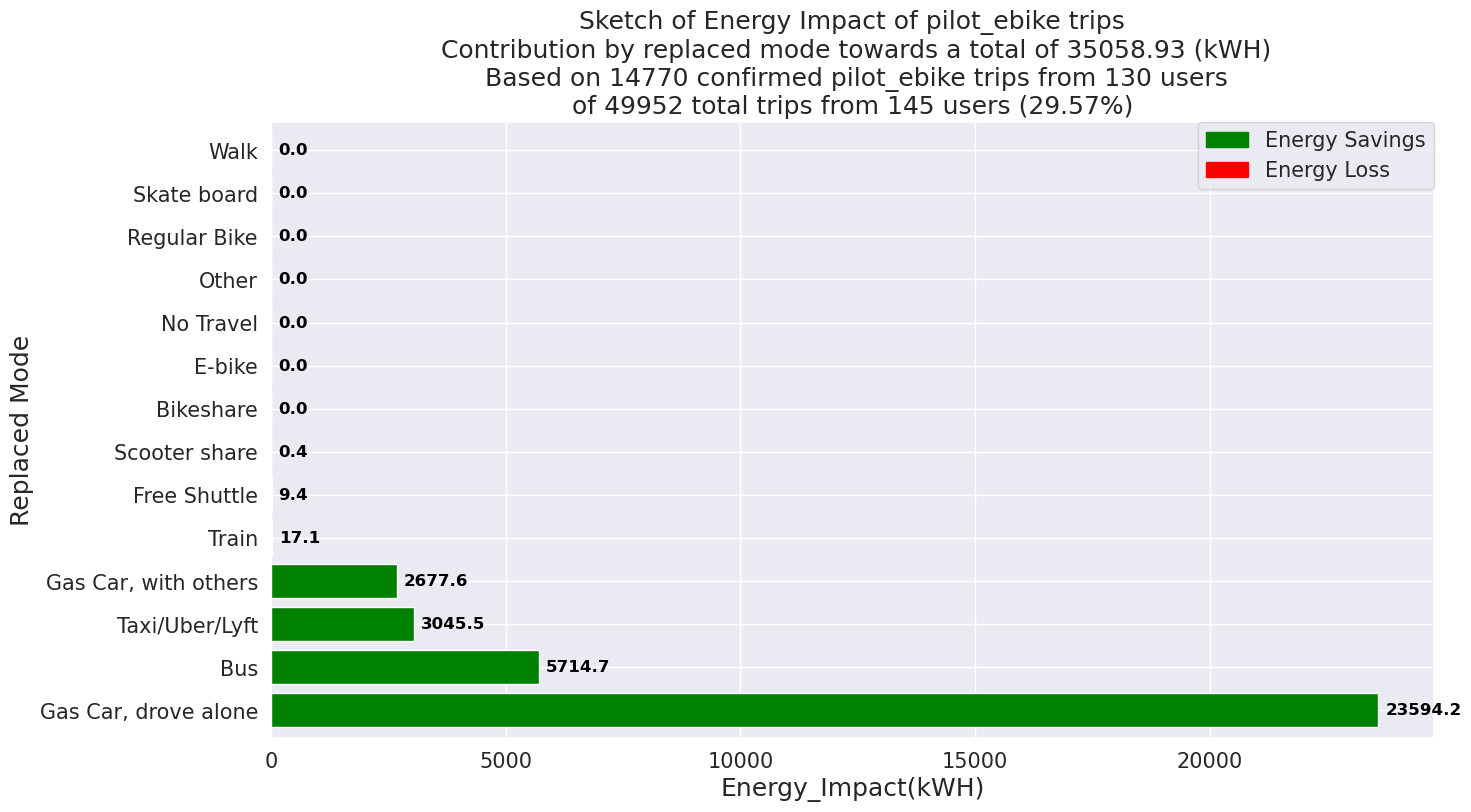

In [10]:
# ebei : ebike energy impact
plot_title_no_quality=f"Sketch of Energy Impact of {mode_of_interest} trips"
file_name =f'sketch_energy_impact_{mode_of_interest}%s' % file_suffix
    
try:
    ebei=data_eb.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
    ebei.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
    ebei= ebei.reset_index()
    ebei = ebei.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
    ebei['boolean'] = ebei['Sketch of Total Energy_Impact(kWH)'] > 0
    net_energy_saved = round(sum(ebei['Sketch of Total Energy_Impact(kWH)']), 2)

    x = ebei['Sketch of Total Energy_Impact(kWH)']
    y = ebei['Replaced_mode']
    color =ebei['boolean']

    plot_title= plot_title_no_quality+f"\n Contribution by replaced mode towards a total of {net_energy_saved}(kWH)\n"+quality_text
    energy_impact(x,y,color,plot_title,file_name)
    alt_text = store_alt_text_bar(pd.DataFrame(x.values,y), file_name, plot_title)
except:
    generate_missing_plot(plot_title_no_quality,debug_df,file_name)
    alt_text = store_alt_text_missing(debug_df, file_name, plot_title_no_quality)

### Sketch of CO2 emissions impact by trips of specified mode

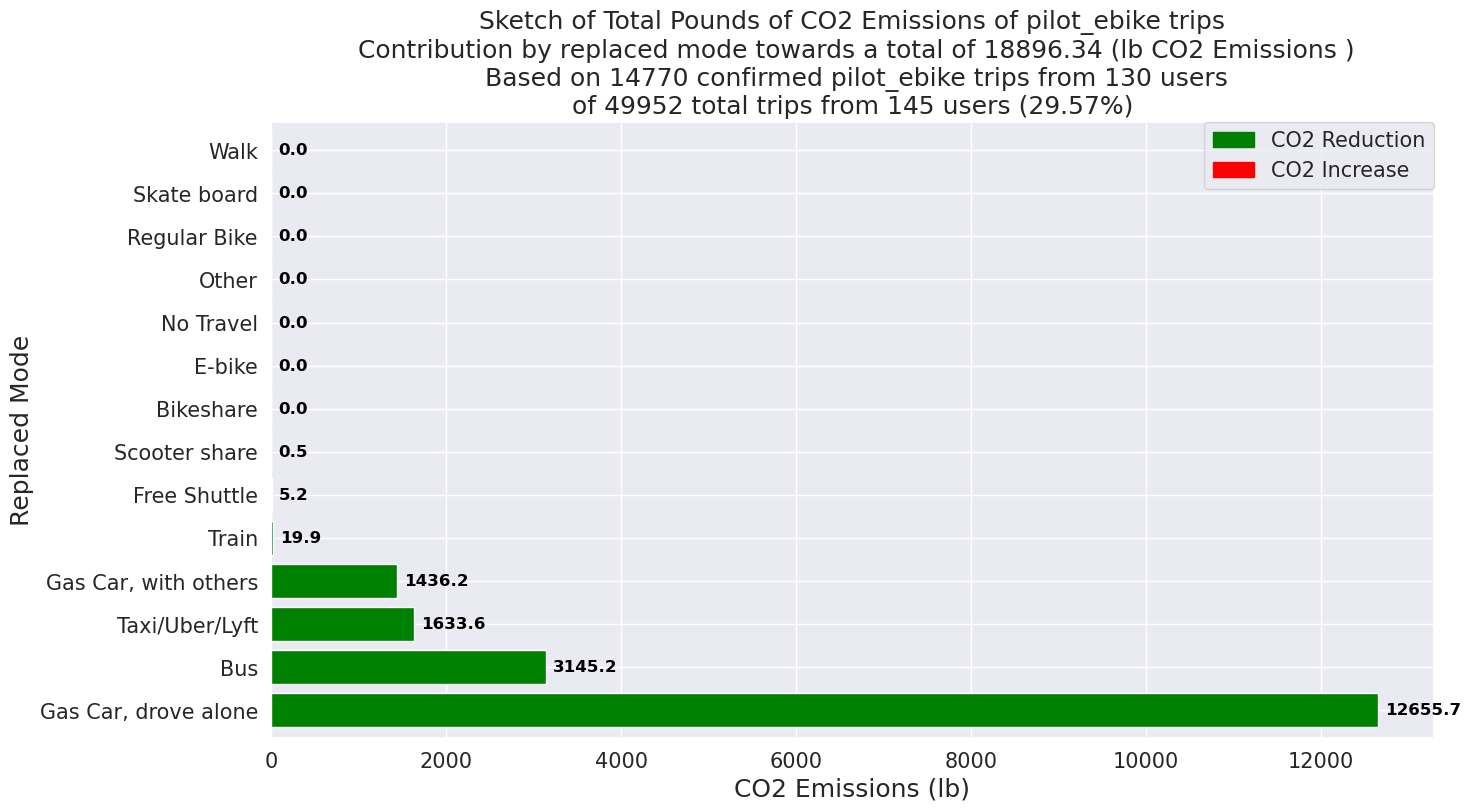

In [12]:
def ebco2_compute(data_eb, weight_unit):
    ebco2=data_eb.groupby('Replaced_mode').agg({f'CO2_Impact({weight_unit})': ['sum', 'mean']},)
    ebco2.columns = [f'total_{weight_unit}_CO2_emissions', f'average_{weight_unit}_CO2_emission']
    ebco2 = ebco2.reset_index()
    ebco2 = ebco2.sort_values(by=[f'total_{weight_unit}_CO2_emissions'], ascending=False)
    return ebco2

def display_total_CO2_emissions(data_eb, weight_unit, weight_unit_debug, mode_of_interest):
    plot_title_no_quality=f"Sketch of Total {weight_unit} of CO2 Emissions of {mode_of_interest} trips"
    file_name =f'sketch_CO2impact_{mode_of_interest}%s' % file_suffix
    
    ebco2 = ebco2_compute(data_eb, weight_unit)
    net_CO2_emissions = round(sum(ebco2[f'total_{weight_unit}_CO2_emissions']), 2)
    ebco2['boolean'] = ebco2[f'total_{weight_unit}_CO2_emissions'] > 0
    x = ebco2[f'total_{weight_unit}_CO2_emissions']
    y = ebco2['Replaced_mode']
    xLabel = f'CO2 Emissions ({weight_unit})'
    yLabel = 'Replaced Mode'
    color = ebco2['boolean']

    plot_title= plot_title_no_quality+f"\n Contribution by replaced mode towards a total of {net_CO2_emissions}({weight_unit} CO2 Emissions )\n"+quality_text
    CO2_impact(x,y,color,plot_title, xLabel,yLabel,file_name)
    alt_text = store_alt_text_bar(pd.DataFrame(x.values,y), file_name, plot_title)

    # For debugging: Computing and displaying Total CO2 emissions in both Metric(kg) and Imperial(lb) unit system for easy comparison.
    if (is_debug_mode == True):
        ebco2_debug = ebco2_compute(data_eb, weight_unit_debug)
        if (weight_unit == 'kg'):
            scaffolding.print_CO2_emission_calculations(data_eb, ebco2_debug, ebco2, dynamic_labels)
        else:
            scaffolding.print_CO2_emission_calculations(data_eb, ebco2, ebco2_debug, dynamic_labels)

try:
    if (len(dynamic_labels) > 0):
        display_total_CO2_emissions(data_eb,'kg','lb', mode_of_interest)
    else:
        display_total_CO2_emissions(data_eb,'lb','kg', mode_of_interest)
except:
    generate_missing_plot(plot_title_no_quality,debug_df,file_name)
    alt_text = store_alt_text_missing(debug_df, file_name, plot_title_no_quality)